## 라이브러리 import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

## KITTI 데이터셋 다운로드

In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

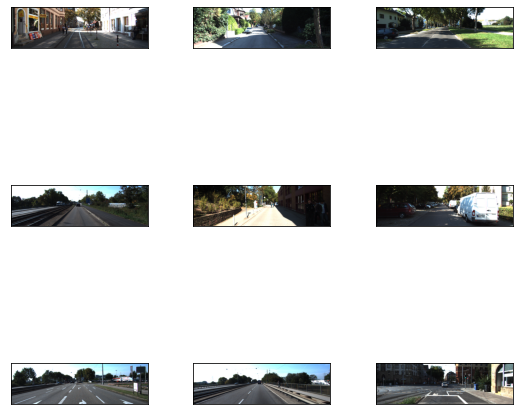

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel-dj17/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
    

## KITTI 데이터셋 분석
- KITTI 데이터셋은 7,481개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성되어 있다. 라벨에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등의 정보가 있다.

## 데이터 직접 확인하기

In [5]:
TakeDataset = ds_train.take(1)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([-0.86, -1.6 , -0.4 , -0.45,  1.6 ], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.0027027 , 0.        , 0.46008107, 0.24726307],
       [0.4148919 , 0.8100817 , 0.6026757 , 0.8409886 ],
       [0.28013512, 0.65357846, 0.56862164, 0.691634  ],
       [0.2653784 , 0.66402775, 0.5519189 , 0.70193624],
       [0.46016216, 0.36089054, 0.53486484, 0.38879085]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1.5 , 1.78, 3.69],
       [1.72, 0.78, 1.71],
       [1.72, 0.55, 0.93],
       [1.62, 0.48, 0.96],
       [1.45, 1.75, 4.23]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-3.17,  1.66,  3.35],
       [10.54,  0.89, 18.47],
       [ 3.74,  1.39, 11.78],
       [ 3.84,  1.4 , 11.17],
       [-8.16,  1.  , 39.71]], dtype=float32)>, 'oc

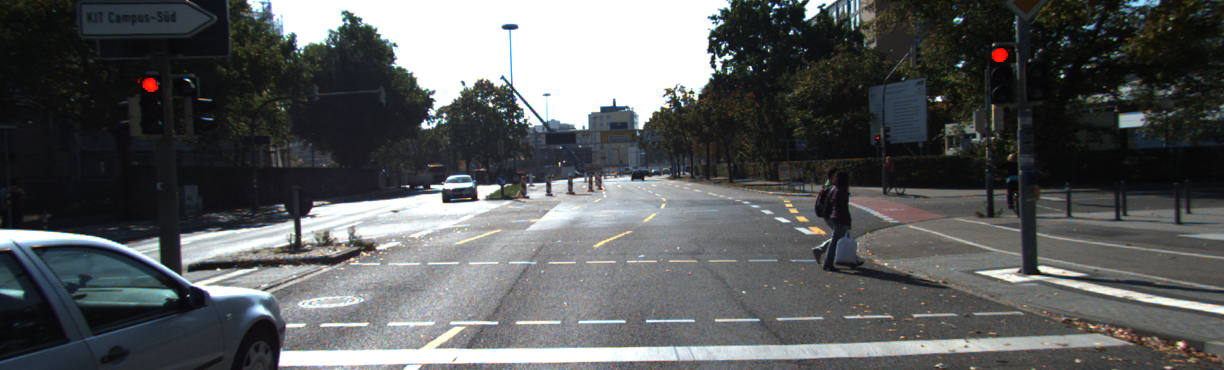

In [6]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(12,), dtype=float32, numpy=
array([-1.58,  1.18,  0.98,  0.94, -1.45,  0.81, -1.75, -1.7 ,  2.9 ,
       -1.61, -1.57,  2.05], dtype=float32)>, 'bbox': <tf.Tensor: shape=(12, 4), dtype=float32, numpy=
array([[0.40216   , 0.47480676, 0.51930666, 0.5183172 ],
       [0.25378665, 0.16109501, 0.49904   , 0.29987922],
       [0.31362668, 0.21975845, 0.5254933 , 0.34758455],
       [0.39738667, 0.29512078, 0.5192    , 0.38457328],
       [0.39394668, 0.40867954, 0.51301336, 0.45822868],
       [0.43906668, 0.35409823, 0.53322667, 0.42543477],
       [0.28872   , 0.5646296 , 0.50432   , 0.65616745],
       [0.38877332, 0.5386393 , 0.7042133 , 0.625781  ],
       [0.36392   , 0.6444283 , 0.54866666, 0.6621417 ],
       [0.47962666, 0.5039533 , 0.60496   , 0.53360707],
       [0.44808   , 0.4789372 , 0.5335733 , 0.5072383 ],
       [0.42234668, 0.17411433, 0.52082664, 0.23943639]], dtype

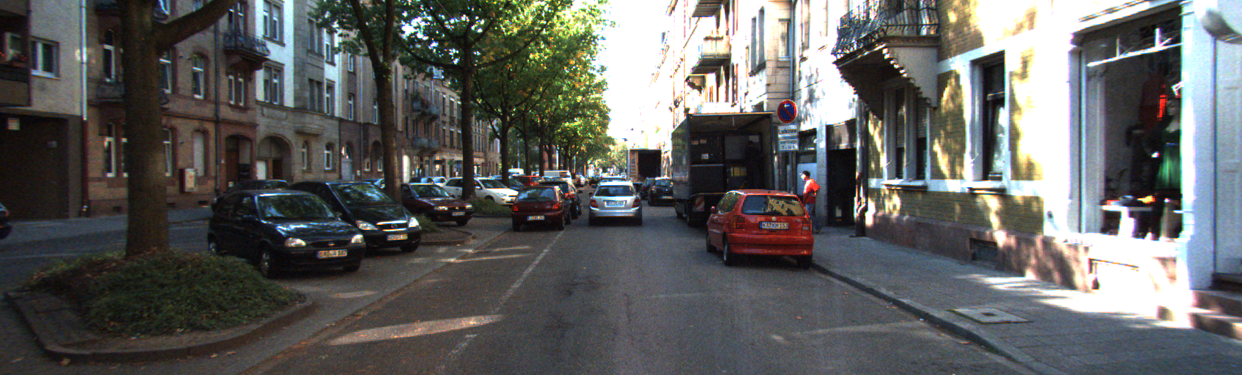

In [7]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

## 이미지 위에 바운딩 박스를 그려서 시각화 하기

width: 1242  height: 375
(12, 4)
[589.70996 224.19    643.75    180.26001]
[200.08    279.83002 372.44998 187.86   ]
[272.94 257.39 431.7  177.94]
[366.54    225.98    477.64    180.29999]
[507.58    227.26999 569.12    182.62   ]
[439.79    210.34999 528.38995 175.04   ]
[701.26996 266.72998 814.95996 185.87999]
[668.99    229.21    777.22003 110.92001]
[800.37994 238.53    822.37994 169.25   ]
[625.91    195.14    662.74    148.13998]
[594.84 206.97 629.99 174.91]
[216.25    216.62    297.38    179.69002]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F976C110590>


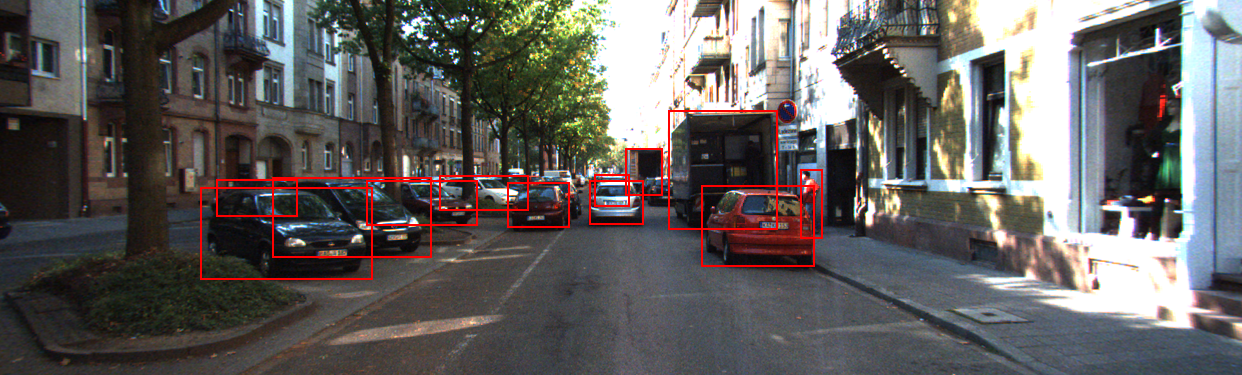

In [8]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## keras-retinanet 데이터 포맷 변경
### 클래스 및 바운딩 박스 정보 추출
- API를 활용하여 데이터를 추출, 이를 포맷팅 하여 CSV 형태로 한 줄씩 저장

In [9]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [13:33<00:00,  7.80it/s]


- 테스트 데이터셋에 대해서도 동일하게 parse_dataset() 을 적용해서 dataframe을 생성

In [10]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:35<00:00,  7.42it/s]


### 클래스 맵핑
- 자동차와 사람 구별

In [11]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

## RetinaNet 학습

In [12]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-26 14:46:02.484673: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-26 14:46:04.279373: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-26 14:46:04.281748: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-26 14:46:04.304991: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-04-26 14:46:04.305033: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aiffeldj17-ROG-Strix-G712LW-G712LW
2021-04-26 14:46:04.305043: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aiffeldj17-ROG-Strix-G712LW-G712LW
2021-04-26 14:46:04.305099: I tensorflow/stream_executor/cuda/cuda_dia

2021-04-26 14:46:08.043344: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-04-26 14:46:08.043758: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
Epoch 1/50
2021-04-26 14:46:09.553822: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.
2021-04-26 14:46:09.600853: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.
195/195 [==============================] - 950s 5s/step - loss: 3.6596 - regression_loss: 2.7014 - classification_loss: 0.9582

Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
Epoch 2/50
195/195 [==============================] - 947s 5s/step - loss: 2.8899 - regression_loss: 2.3316 - classification_loss: 0.5583

Epoch 00002: saving model to ./snapshots/resnet50_csv_02.h5
Epoch 3/50
 15/195 [=>............................

In [13]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-26 15:19:04.460217: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-26 15:19:06.432914: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-26 15:19:06.437076: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-26 15:19:06.471304: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-04-26 15:19:06.471335: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aiffeldj17-ROG-Strix-G712LW-G712LW
2021-04-26 15:19:06.471341: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aiffeldj17-ROG-Strix-G712LW-G712LW
2021-04-26 15:19:06.471439: I tensorflow/stream_executor/cuda/cuda_dia

## keras-retinanet 시각화

In [14]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

## inference_on_image 함수 구현하기
- 최종적으로 retinanet으로 학습해서 detection한 결과를 이미지에 출력한다.

In [59]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            print(score)
            if score < 0.4:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)
            print(label)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()  




[  5.2199383 185.27069   222.68852   306.43118  ]
0.31875432


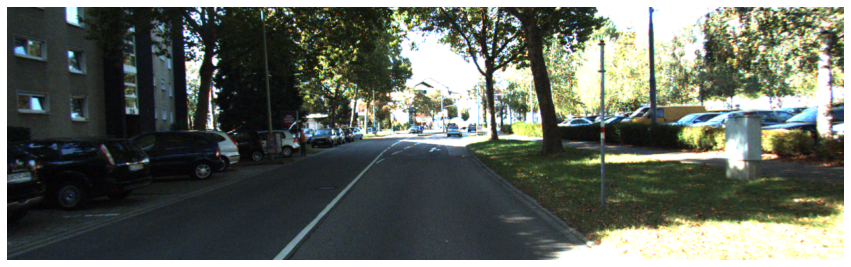

In [64]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_5.png'
inference_on_image(model, img_path=img_path)

## 자율주행 보조 시스템 만들기
- inference_on_image() 함수 잘 활용해서 self_drive_assist()함수를 만들었다.
- 마지막에 사람이나 큰 자동차(300px이상) 만나면 "Stop", 나머지는 "Go"를 반환하는 함수이다.

In [74]:
def self_drive_assist(model, img_path="./test_set/go_1.png", visualize=True, size_limit=300):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):

            b = box.astype(int)
            box_width = b[2]-b[0]
            box_height = b[3]-b[1]
            if score < 0.4:
                break
            
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)
            
            if label == 1 or (label == 0 and (box_width >= size_limit or box_height >= size_limit)) :
                return "Stop"
            
            else :
                return "Go"
        
        return "Go"

In [75]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_5.png'
self_drive_assist(model, img_path)

'Go'

## 자율주행 시스템 평가하기
- 아래 test_system() 함수를 통해서 위에서 만든 함수를 평가봤다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해준다.

In [76]:
import os

def test_system(model, func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(model, image_path)
        if pred == answer:
            score += 10
            print(score)
        else :
            print(image_path)
    print(f"{score}점입니다.")

test_system(model, self_drive_assist)

10
20
30
40
50
60
70
80
90
100
100점입니다.


# 마치며...
- 처음에 어떻게 평가해야할지 조금 막막했다. 하지만 변수인 score, label, b 등 여러 값을 하나씩 print로 찍어보며 값을 확인해보니 조금씩 해결 아이디어가 떠올라서 재미있었다. 